In [1]:
## METRIC : ACCURACY FOR THIS CHALLENGE
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from datetime import datetime
#%matplotlib inline
import seaborn as sns
import warnings
sns.set()

The metric in the rules is the number of missclassified data points, so accuracy_score seems the most logical choice.

In [2]:
train=pd.read_csv('C:/Users/Amine/Desktop/Zindi_Competition/Train_v2.csv')
test=pd.read_csv('C:/Users/Amine/Desktop/Zindi_Competition/Test_v2.csv')
submission_file=pd.read_csv('C:/Users/Amine/Desktop/Zindi_Competition/SubmissionFile_Zindi.csv')
Variables=pd.read_csv('C:/Users/Amine/Desktop/Zindi_Competition/VariableDefinitions_Zindi.csv')

We will be predicting if a person has a bank account or not using variables given in datasets. So this is a binary classification problem, and the algorithms used here, and the metric are specific to this problem.

In [3]:
Variables

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
5,household_size,Number of people living in one house
6,age_of_respondent,The age of the interviewee
7,gender_of_respondent,"Gender of interviewee: Male, Female"
8,relationship_with_head,The interviewee’s relationship with the head o...
9,marital_status,The martial status of the interviewee: Married...


###### Descriptive statistics about our data

In [4]:
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


How the 5 first rows in the trainset look like!

In [5]:
train.isnull().sum()

country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

No nulls. great!

In [6]:
train.describe()

,year,household_size,age_of_respondent
count,23524.000000,23524.000000,23524.000000
mean,2016.975939,3.797483,38.805220
std,0.847371,2.227613,16.520569
min,2016.000000,1.000000,16.000000
25%,2016.000000,2.000000,26.000000
50%,2017.000000,3.000000,35.000000
75%,2018.000000,5.000000,49.000000
max,2018.000000,21.000000,100.000000


3 numerical columns only. Most of the columns are categorical.

In [7]:
train.dtypes

country                   object
year                       int64
uniqueid                  object
bank_account              object
location_type             object
cellphone_access          object
household_size             int64
age_of_respondent          int64
gender_of_respondent      object
relationship_with_head    object
marital_status            object
education_level           object
job_type                  object
dtype: object

###### dataset balance?

Lets see if our dataset is balanced or not by checking our target distribution.

In [8]:
train.bank_account.value_counts()

No     20212
Yes     3312
Name: bank_account, dtype: int64

In [9]:
a = len(train[train.bank_account=='Yes'])
b = len(train[train.bank_account=='No'])
c = len(train)
print('We have an imbalanced dataset with a %i/%i ratio'%((b/c*100),(a/c*100)+1))

We have an imbalanced dataset with a 85/15 ratio


Stratification will be needed when doing cross-validation to preserve this ratio in our folds!

###### The id+country thing

In [10]:
train.uniqueid.value_counts().head(5)

uniqueid_1304    4
uniqueid_1053    4
uniqueid_1112    4
uniqueid_1423    4
uniqueid_1884    4
Name: uniqueid, dtype: int64

some uniqueid's have the same value 4 times. this can be explained by the number of countries in the dataset. Hence the need to identify people by 'country'+'uniqueid' to avoid having duplicate uniqueid values.

In [11]:
test.uniqueid.value_counts().head(5)

uniqueid_8620    3
uniqueid_8664    3
uniqueid_8633    3
uniqueid_8547    3
uniqueid_8666    3
Name: uniqueid, dtype: int64

Same thing needs to be done for the test set.

### Exploratory Data Analysis

Lets start one variable at a time, see the distribution, then plot it against the target!

#### Distributions

###### age_of_respondant

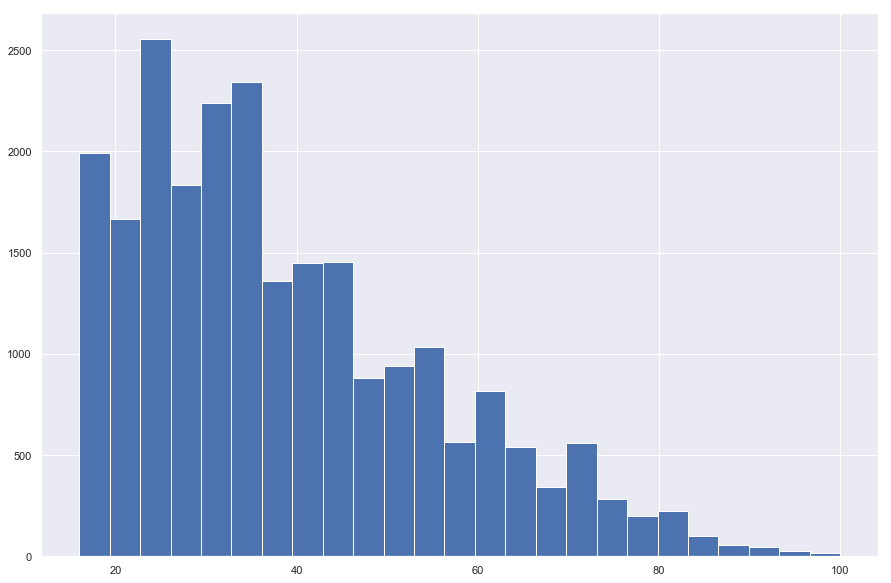

In [12]:
hist_age = train.age_of_respondent.hist(bins=25,figsize=[15,10])

We have a skewed to the right distribution for this variable. Lets try to make it look like a bit more Gaussian by applying x to log base 10 of x and sqrt

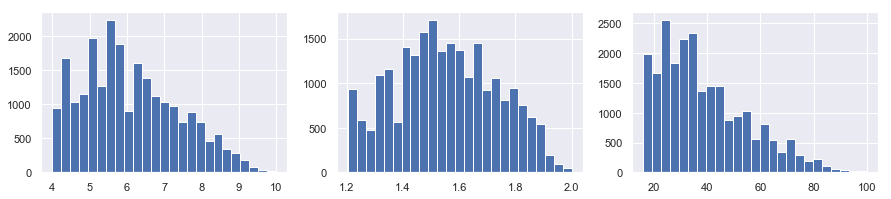

In [13]:
log_age = train.age_of_respondent.apply(np.log10)
root_age = train.age_of_respondent.apply(np.sqrt)
plt.subplot(331)
hist_sqrt_age = root_age.hist(bins=25,figsize=[15,10]) ## sqrt applied to age
plt.subplot(332)
hist_log_age = log_age.hist(bins=25,figsize=[15,10]) ## log10 applied to age
plt.subplot(333)
hist_age = train.age_of_respondent.hist(bins=25,figsize=[15,10]) ## original distribution

The middle distribution ( log10 ) looks the most normal. We can see on the far right histogram that the mean of age equal to 38 given by the describe() makes sense given this distribution.

###### country

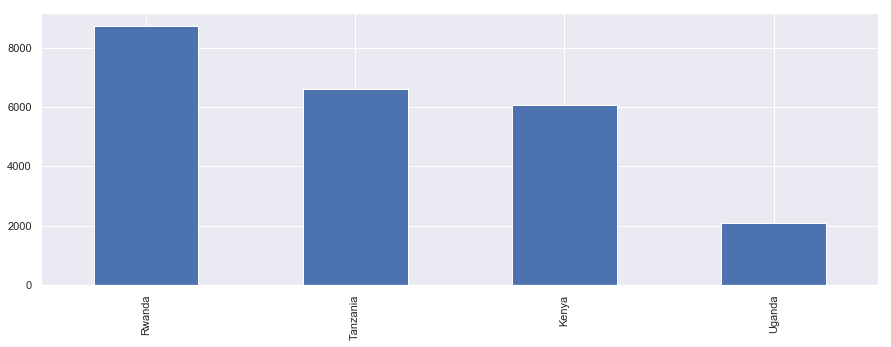

In [14]:
train['country'].value_counts().plot(kind='bar',figsize=[15,5])

Rwanda is the most occuring value for country, while Uganda is the least occuring one.

###### location type

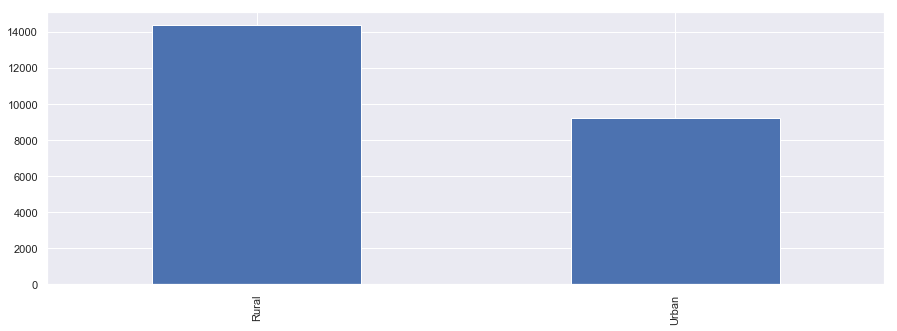

In [15]:
train['location_type'].value_counts().plot(kind='bar',figsize=[15,5])

More people from rural places have been interviewed than people in urban places.

###### cellphone access

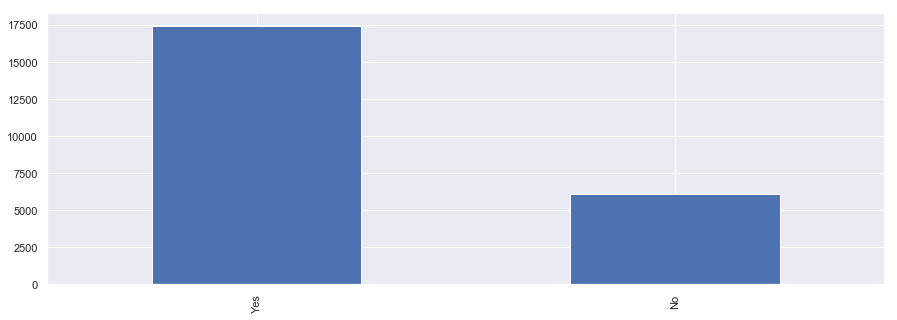

In [16]:
train['cellphone_access'].value_counts().plot(kind='bar',figsize=[15,5])

Looking at the data beforehand, one could guess that this variable would turn out to be a very good predictor, but looking at this distribution and the target distribution it seems not unless 'Yes' indicates the non-possession of a bank account which is unlikely.

###### household_size

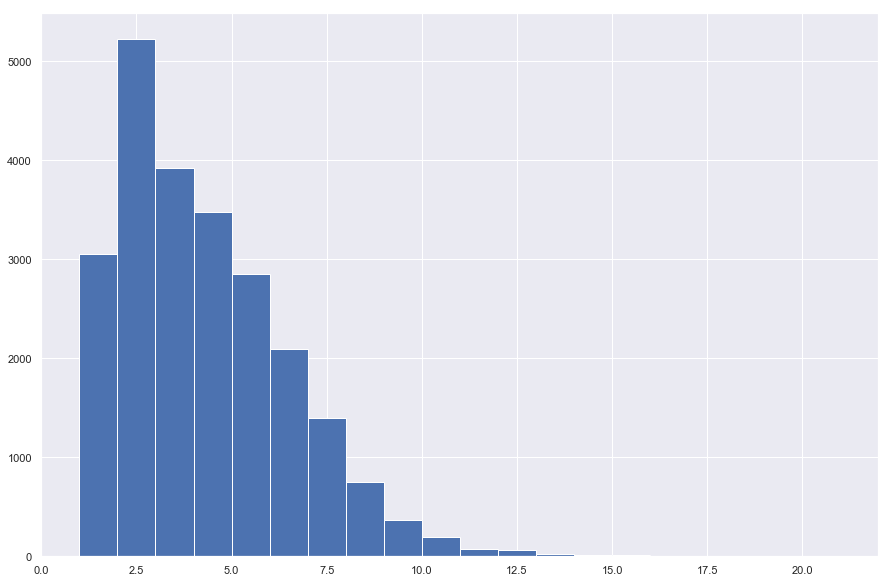

In [17]:
hist_hs = train.household_size.hist(bins=20,figsize=[15,10])

Another numerical distribution that's skewed to the right. Average would be around 3

###### gender of respondant

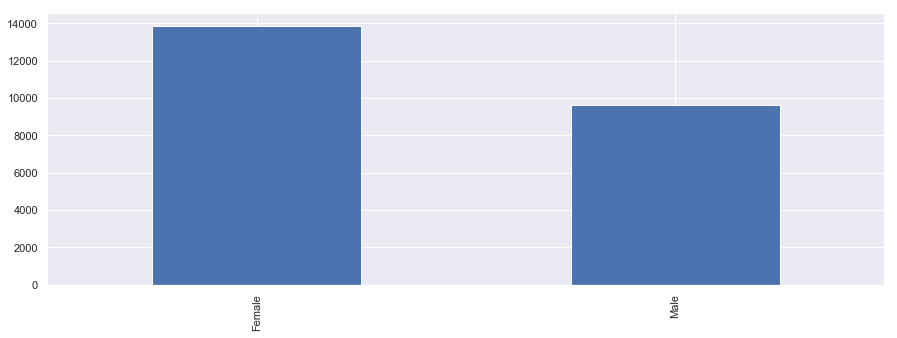

In [18]:
train['gender_of_respondent'].value_counts().plot(kind='bar',figsize=[15,5])

Trainset has more females than males.

###### relationship with head

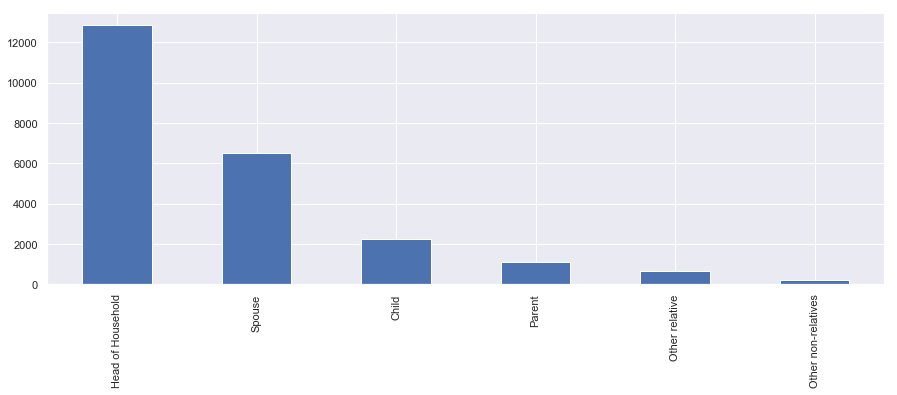

In [19]:
train['relationship_with_head'].value_counts().plot(kind='bar',figsize=[15,5])

This variable has 6 categories that are uneven in terms of distribution. The most occuring category is 'Head of Household' followed by Spouse. These two categories represent 70%+ of the trainset.

###### marital status

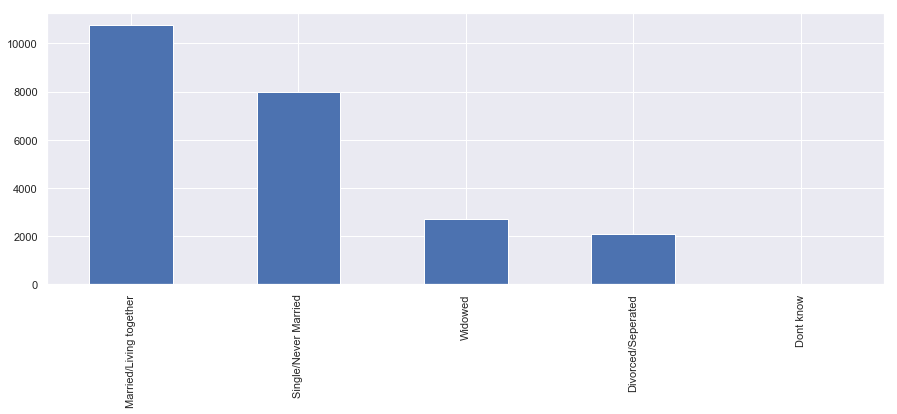

In [20]:
train['marital_status'].value_counts().plot(kind='bar',figsize=[15,5])

5 categories with one category 'Don't know' being significantly undersampled

###### education_level

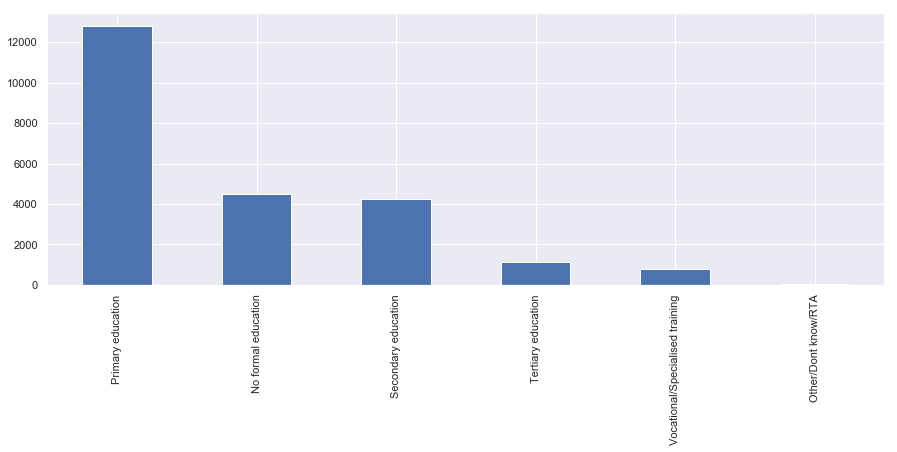

In [21]:
train['education_level'].value_counts().plot(kind='bar',figsize=[15,5])

7 categories, one category is called '6' and is undersampled; another category is 'Other/Dont know/RTA' is also undersampled

###### Job_type

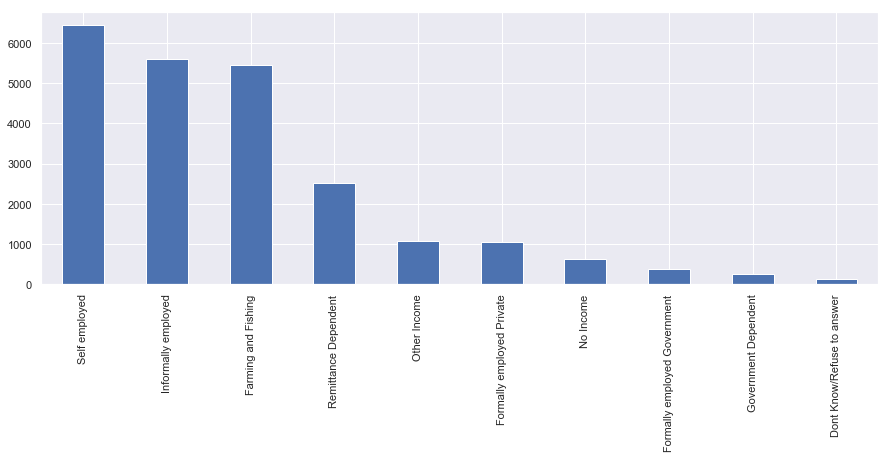

In [22]:
train['job_type'].value_counts().plot(kind='bar',figsize=[15,5])

We have a number of categories while 3 are dominant, the rest are close in terms of distribution.

#### How was the split made? was it random? is it following a trend?

if you submit a constant prediction equal to 0, you'll get an accuracy score indicating how many 0 and how many 1 there are in the test set ( this is called test set probing ). I did that, the ratio is 85/15 same as the train set which means the train/test split wasn't completely random. Again stratification will be needed when cross-validating

###### Let's check the ratios for the country variable

In [23]:
a=len(test[test.country=='Rwanda'])
b=len(test[test.country=='Kenya'])
c=len(test[test.country=='Tanzania'])
d=len(test[test.country=='Uganda'])
f = len(test)
print('Rwanda %i%% Kenya %i%% Tanzania %i%% Uganda %i%%'%(a/f*100,b/f*100,c/f*100,d/f*100))

Rwanda 37% Kenya 25% Tanzania 28% Uganda 8%


In [24]:
a=len(train[train.country=='Rwanda'])
b=len(train[train.country=='Kenya'])
c=len(train[train.country=='Tanzania'])
d=len(train[train.country=='Uganda'])
f = len(train)
print('Rwanda %i%% Kenya %i%% Tanzania %i%% Uganda %i%%'%(a/f*100,b/f*100,c/f*100,d/f*100))

Rwanda 37% Kenya 25% Tanzania 28% Uganda 8%


The ratios are exactly the same for the train and test set. Again the split wasn't made on a random basis. Understanding how the split was made to create the test set helps give an idea on how to split your data when doing cross-validation.

###### Let's check the year variable

In [25]:
test.year.value_counts()

2016    3745
2018    3502
2017    2839
Name: year, dtype: int64

In [26]:
train.year.value_counts()

2016    8735
2018    8169
2017    6620
Name: year, dtype: int64

Same thing, the year seems to have been a condition to be respected when splitting the train/test

In [27]:
train[train.year==2016].country.value_counts()

Rwanda    8735
Name: country, dtype: int64

In [28]:
train[train.year==2017].country.value_counts()

Tanzania    6620
Name: country, dtype: int64

In [29]:
train[train.year==2018].country.value_counts()

Kenya     6068
Uganda    2101
Name: country, dtype: int64

The year variable is indicative of which country is mentionned. That's how the train set is made. Same goes for test set. So the year variable is useless, we can determine what 'year' it is by knowing the 'country'.

In [30]:
test[test.uniqueid.duplicated(keep=False)].sort_values(by='uniqueid').head(6)

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
421,Kenya,2018,uniqueid_6490,Urban,Yes,1,25,Female,Head of Household,Divorced/Seperated,Primary education,Informally employed
6346,Tanzania,2017,uniqueid_6490,Rural,Yes,3,33,Male,Head of Household,Single/Never Married,Secondary education,Self employed
6347,Tanzania,2017,uniqueid_6498,Urban,Yes,2,22,Female,Spouse,Single/Never Married,Secondary education,Self employed
429,Kenya,2018,uniqueid_6498,Rural,Yes,4,36,Male,Head of Household,Married/Living together,Secondary education,Farming and Fishing
433,Kenya,2018,uniqueid_6502,Urban,Yes,4,33,Female,Spouse,Married/Living together,Primary education,Self employed
6348,Tanzania,2017,uniqueid_6502,Rural,Yes,7,42,Female,Parent,Divorced/Seperated,Secondary education,Self employed


In [31]:
train[train.uniqueid.duplicated(keep=False)].sort_values(by='uniqueid').head(4)

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
14803,Tanzania,2017,uniqueid_1,No,Rural,Yes,6,22,Female,Child,Divorced/Seperated,Secondary education,No Income
21423,Uganda,2018,uniqueid_1,No,Rural,No,5,32,Female,Head of Household,Divorced/Seperated,Primary education,Other Income
6068,Rwanda,2016,uniqueid_1,No,Urban,Yes,7,18,Female,Child,Single/Never Married,Secondary education,Remittance Dependent


Trying to find a pattern between duplicated id's in the trainset. and maybe apply it in the test set. Note that in the test set 5k people exist as duplicate id's. The other 5k are UNIQUE id's and the other equal id's exist in the trainset. If a pattern exists in the trainset , we can probably use that information as a potential leak. But i found nothing.

I was suspecting when i was looking at the dataset that a 'female' and a 'spouse' is more likely to have a bank_account if her husband has a 'bank_account' but relationship between people in the dataset doesn't exist, so pursuing this is probably pointless. Still it's an interesting idea if we can tie this together.

In [32]:
train[(train.relationship_with_head=='Spouse')].bank_account.value_counts()

No     5825
Yes     695
Name: bank_account, dtype: int64

#### Bivariate Analysis using the target

In [33]:
## target encoding
di = {"Yes": 1, "No": 0}
train.replace({"bank_account": di},inplace=True)

###### age_of_respondent 

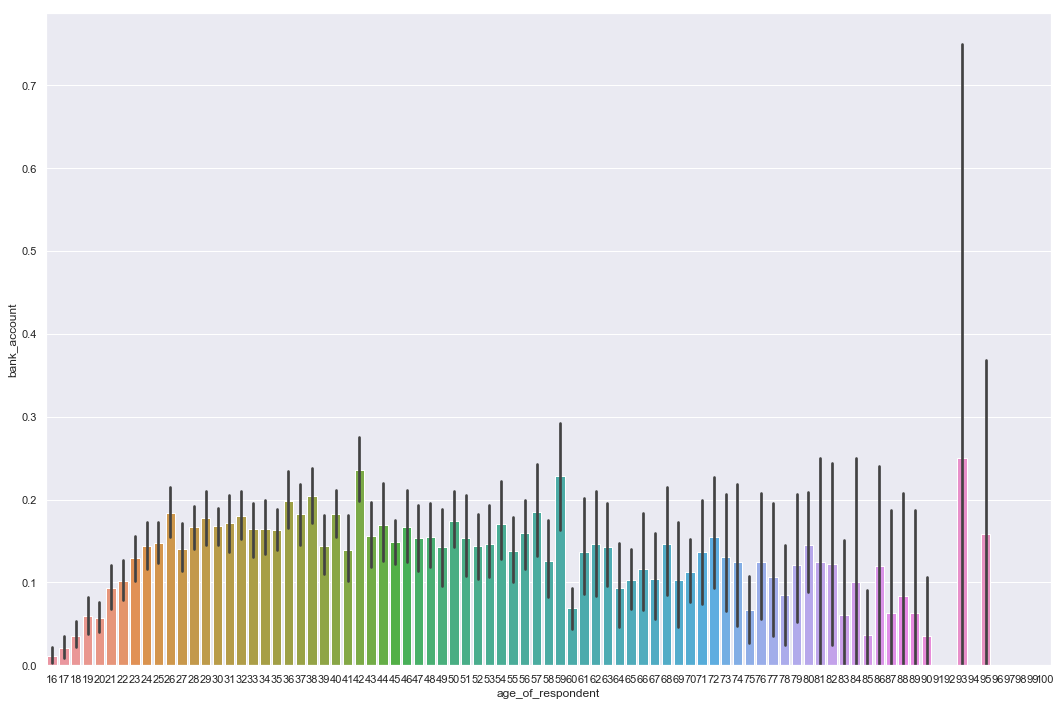

In [34]:
plt.figure(figsize=[18,12])
sns.barplot('age_of_respondent', 'bank_account', data=train)

We can safely say that ,generally speaking and by also looking at the general trend of the plot, older people are less likely to have a bank_account. We have some outliers beyond the 90 mark for the age variable.

###### Gender_of_respondent

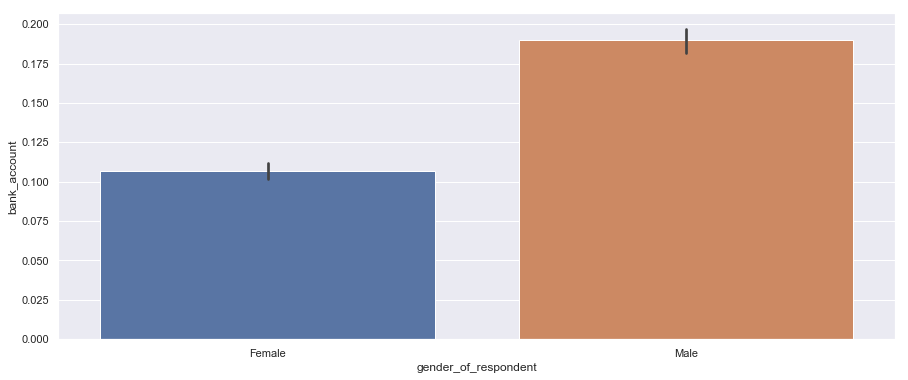

In [35]:
plt.figure(figsize=[15,6])
sns.barplot('gender_of_respondent', 'bank_account', data=train)

Males are more likely to have a bank account according to this plot. Maybe we can combine gender and age, and see if put together, we could notice something and create a feature that better represents this combination.

###### age+gender ?

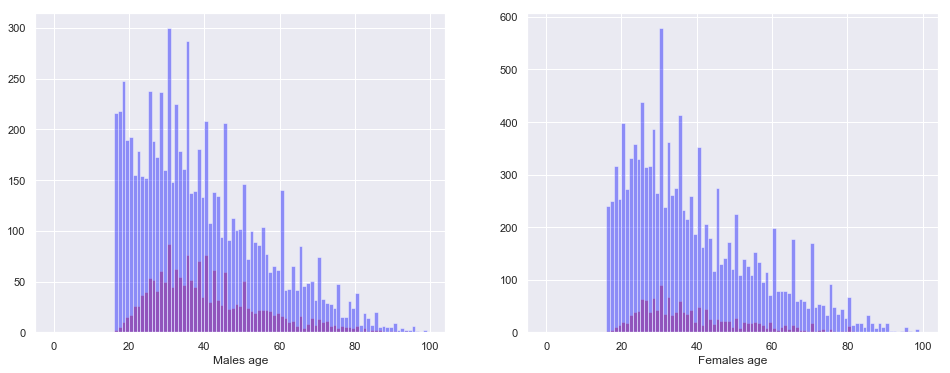

In [36]:
warnings.filterwarnings(action="ignore")
plt.figure(figsize=[25,20])
plt.subplot(331)
sns.distplot(train[(train.gender_of_respondent=='Male')&(train.bank_account==1)]['age_of_respondent'].dropna().values, bins=range(0, 100, 1), kde=False, color='red')
sns.distplot(train[(train.gender_of_respondent=='Male')&(train.bank_account==0)]['age_of_respondent'].dropna().values, bins=range(0, 100, 1), kde=False, color='blue',
            axlabel='Males age')
plt.subplot(332)
sns.distplot(train[(train.gender_of_respondent=='Female')&(train.bank_account==1)]['age_of_respondent'].dropna().values, bins=range(0, 100, 1), kde=False, color='red')
sns.distplot(train[(train.gender_of_respondent=='Female')&(train.bank_account==0)]['age_of_respondent'].dropna().values, bins=range(0, 100, 1), kde=False, color='blue',
            axlabel='Females age')

In [37]:
train.gender_of_respondent.value_counts()

Female    13877
Male       9647
Name: gender_of_respondent, dtype: int64

For both genders, the peak in the likelihood of having a bank_account happens between 20-40. But the number of males , keeping in mind that in the trainset they are less than females by 4k, who have a bank_account is closer to those who don't compared to females. Meaning, age plays a role for both genders almost the same way, but gender has an important role.

###### Country

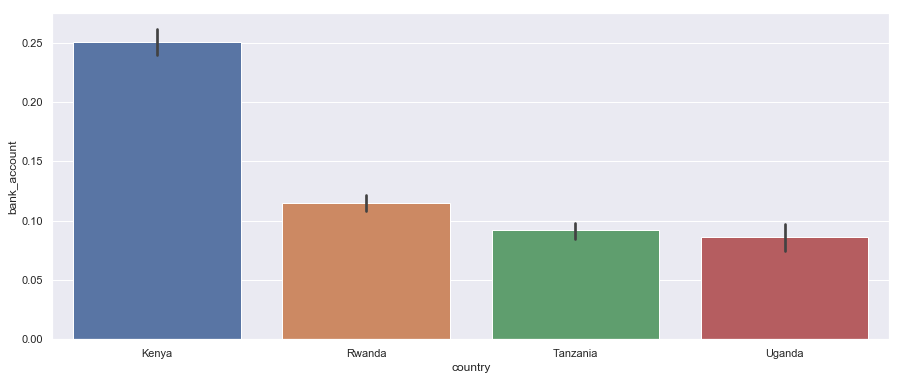

In [38]:
plt.figure(figsize=[15,6])
sns.barplot('country', 'bank_account', data=train)

###### Country+Age

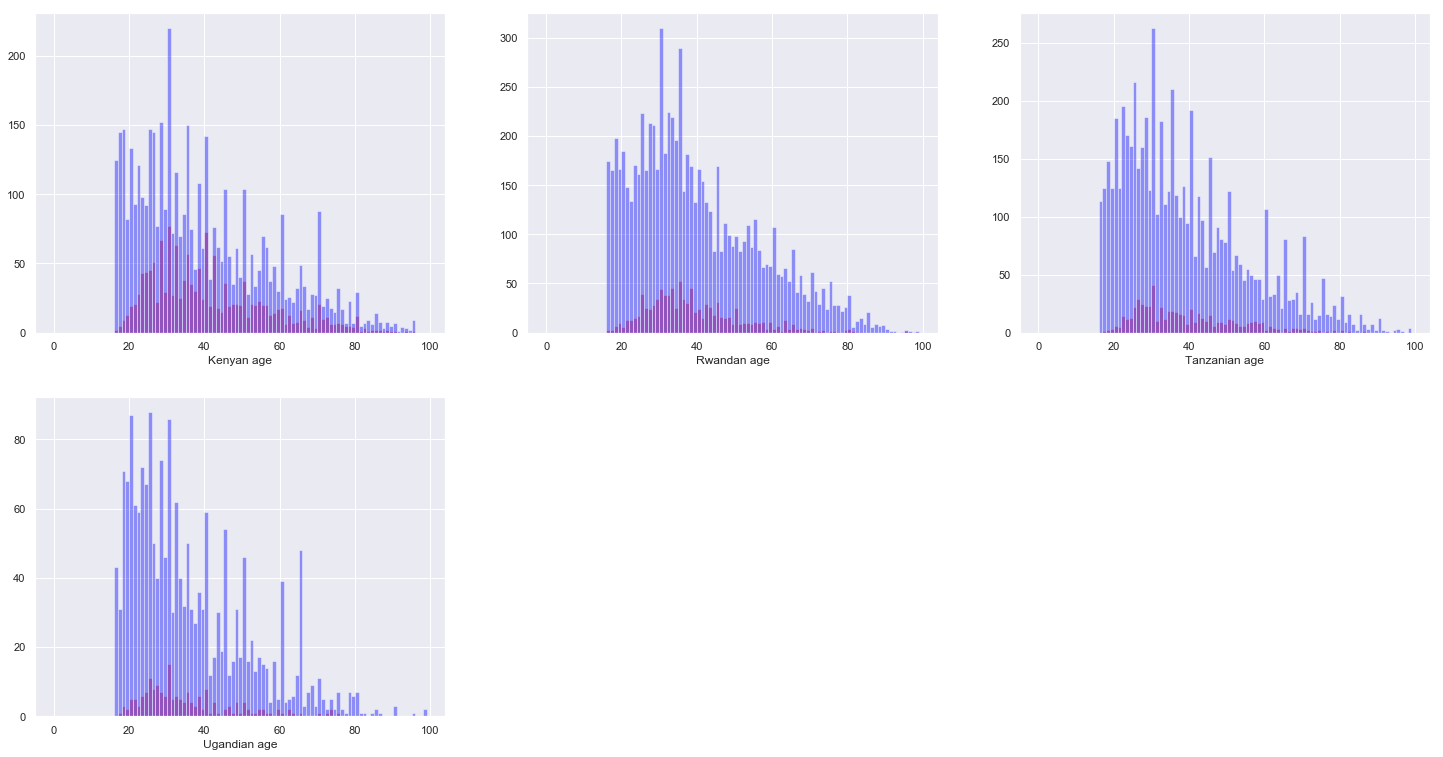

In [39]:
warnings.filterwarnings(action="ignore")
plt.figure(figsize=[25,20])
plt.subplot(331)
sns.distplot(train[(train.country=='Kenya')&(train.bank_account==1)]['age_of_respondent'].dropna().values, bins=range(0, 100, 1), kde=False, color='red')
sns.distplot(train[(train.country=='Kenya')&(train.bank_account==0)]['age_of_respondent'].dropna().values, bins=range(0, 100, 1), kde=False, color='blue',
            axlabel='Kenyan age')
plt.subplot(332)
sns.distplot(train[(train.country=='Rwanda')&(train.bank_account==1)]['age_of_respondent'].dropna().values, bins=range(0, 100, 1), kde=False, color='red')
sns.distplot(train[(train.country=='Rwanda')&(train.bank_account==0)]['age_of_respondent'].dropna().values, bins=range(0, 100, 1), kde=False, color='blue',
            axlabel='Rwandan age')
plt.subplot(333)
sns.distplot(train[(train.country=='Tanzania')&(train.bank_account==1)]['age_of_respondent'].dropna().values, bins=range(0, 100, 1), kde=False, color='red')
sns.distplot(train[(train.country=='Tanzania')&(train.bank_account==0)]['age_of_respondent'].dropna().values, bins=range(0, 100, 1), kde=False, color='blue',
            axlabel='Tanzanian age')
plt.subplot(334)
sns.distplot(train[(train.country=='Uganda')&(train.bank_account==1)]['age_of_respondent'].dropna().values, bins=range(0, 100, 1), kde=False, color='red')
sns.distplot(train[(train.country=='Uganda')&(train.bank_account==0)]['age_of_respondent'].dropna().values, bins=range(0, 100, 1), kde=False, color='blue',
            axlabel='Ugandian age')

###### Country+gender

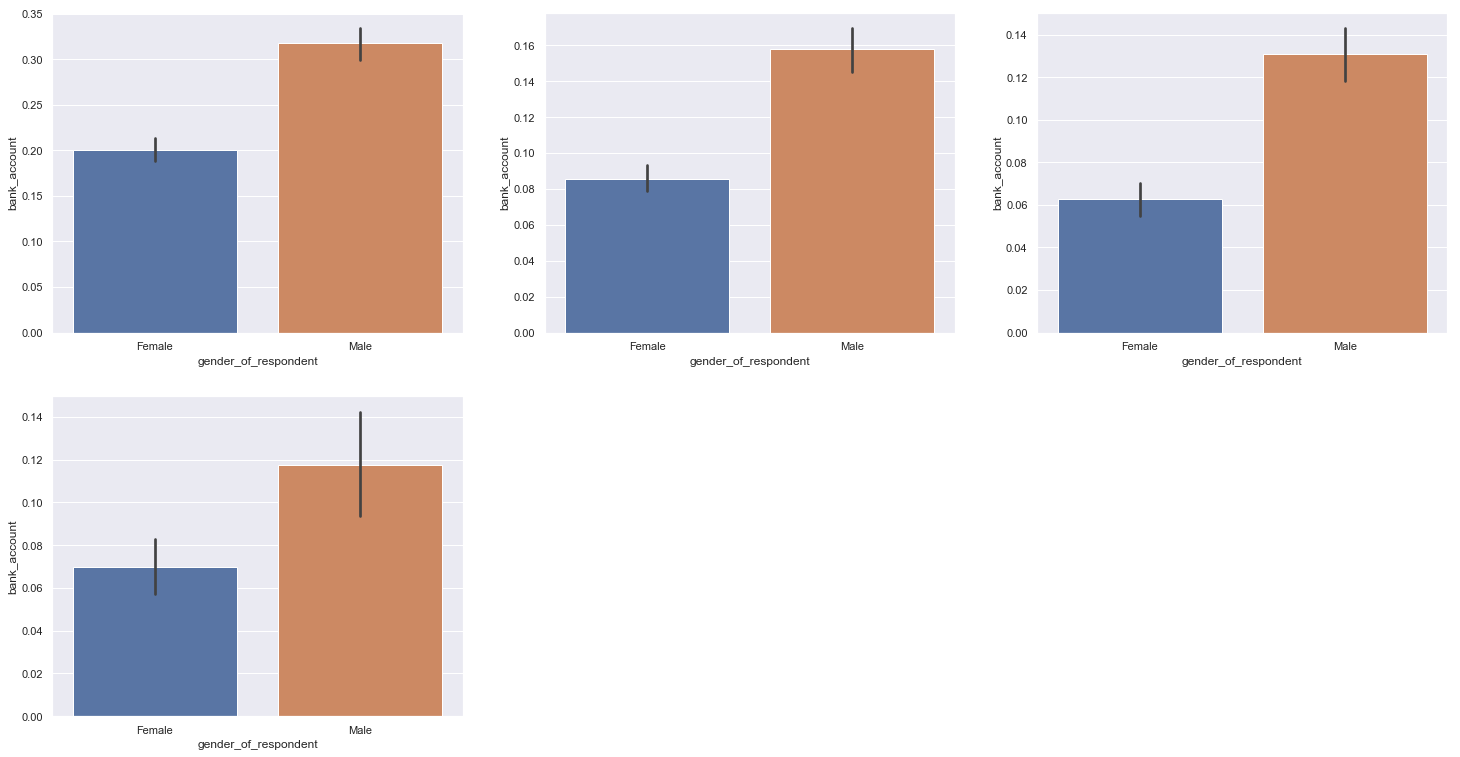

In [40]:
plt.figure(figsize=[25,20])
plt.subplot(331)
sns.barplot('gender_of_respondent', 'bank_account', data=train[(train.country=='Kenya')])
plt.subplot(332)
sns.barplot('gender_of_respondent', 'bank_account', data=train[(train.country=='Rwanda')])
plt.subplot(333)
sns.barplot('gender_of_respondent', 'bank_account', data=train[(train.country=='Tanzania')])
plt.subplot(334)
sns.barplot('gender_of_respondent', 'bank_account', data=train[(train.country=='Uganda')])

###### Job_type

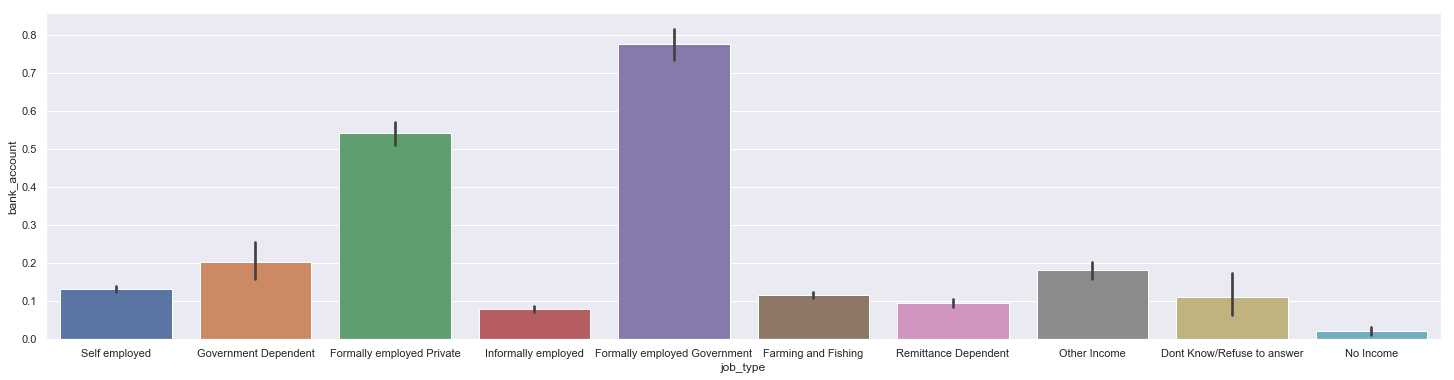

In [41]:
plt.figure(figsize=[25,6])
sns.barplot('job_type', 'bank_account', data=train)

###### Education_level

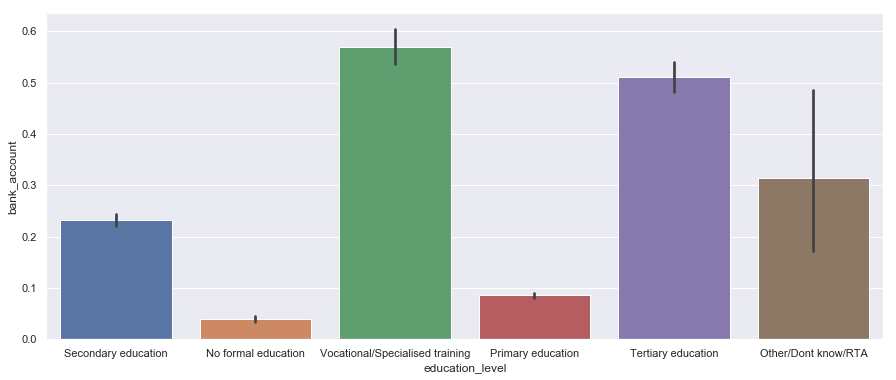

In [42]:
plt.figure(figsize=[15,6])
sns.barplot('education_level', 'bank_account', data=train)

###### Household_size

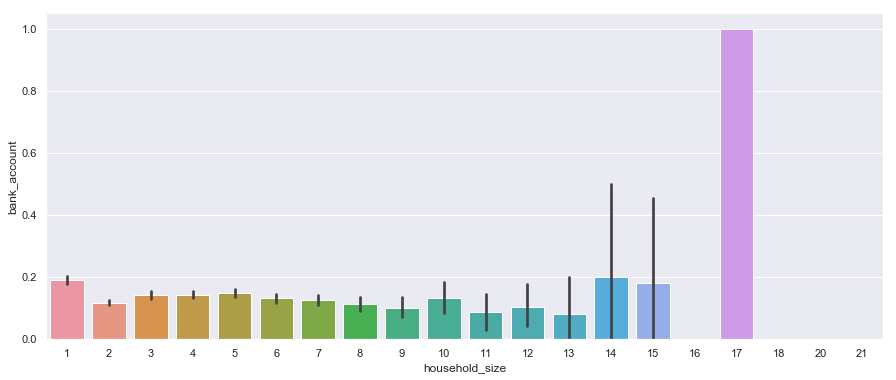

In [44]:
plt.figure(figsize=[15,6])
sns.barplot('household_size', 'bank_account', data=train)

Data needs to be cleaned to get something useful out of this variable. as you can see the bigger values has fewer samples and they might also have outliers.

##### Relationship with head

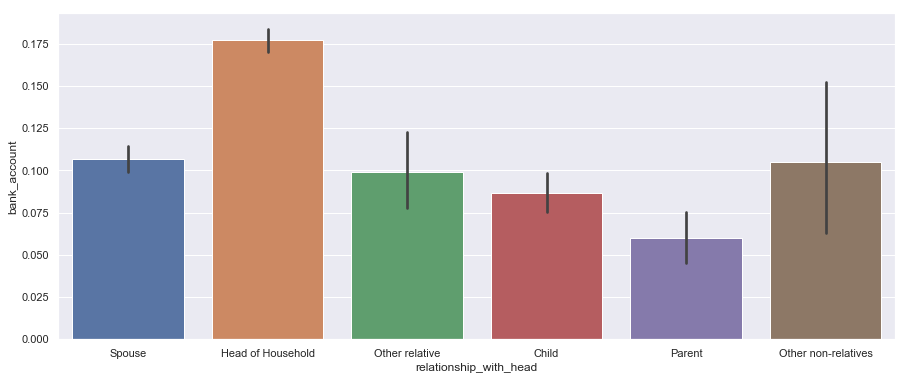

In [45]:
plt.figure(figsize=[15,6])
sns.barplot('relationship_with_head', 'bank_account', data=train)

Some differences of the target distribution across the categories. 

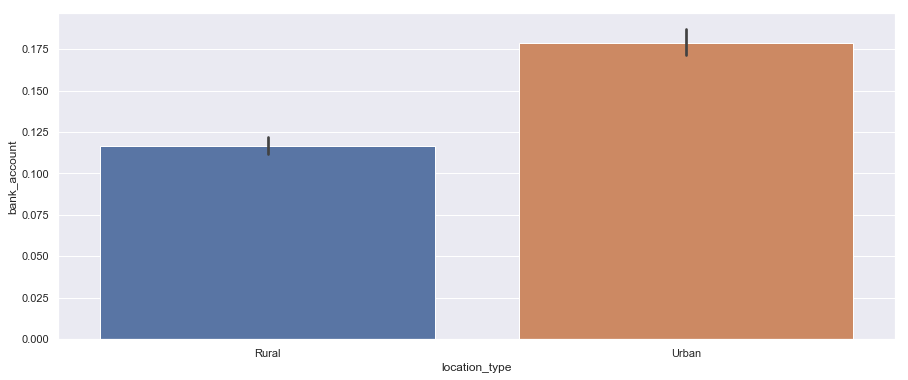

In [51]:
plt.figure(figsize=[15,6])
sns.barplot('location_type', 'bank_account', data=train)

Urban is more likely to be owning a bank_account

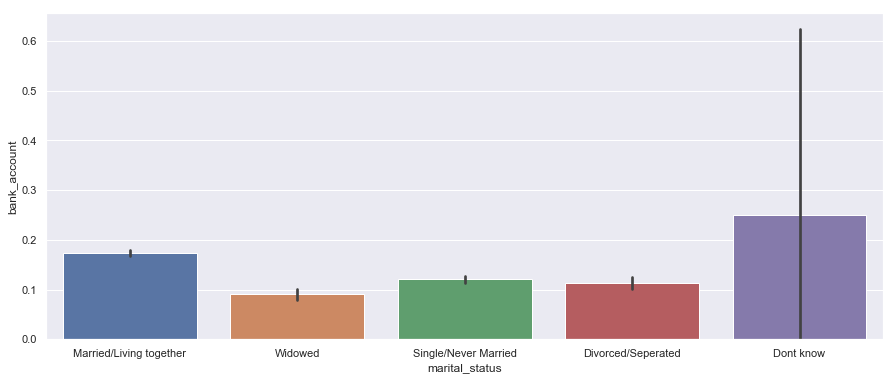

In [48]:
plt.figure(figsize=[15,6])
sns.barplot('marital_status', 'bank_account', data=train)

almost similar across all categories, the undersampled Dont know with 38 samples might cause a problem.

##### Lets see interactions between features

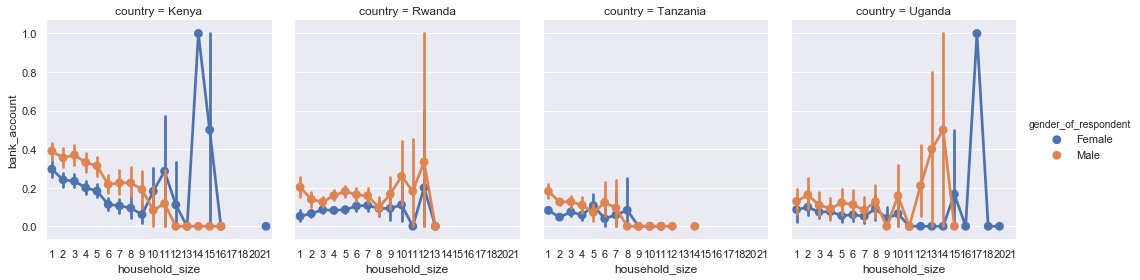

In [103]:
g = sns.factorplot(x="household_size", y="bank_account", hue="gender_of_respondent", col="country",
                   data=train, aspect=0.9, size=4, ci=95.0)

for Kenyans, we can see that household_size is inversely proportionnal to the target, except for some outliers that mess up the plot at bigger household_size values. For Tanzanians , the decline is clearer with lesser outliers. Uganda and Rwanda also have a small decline but the outliers are at it again.

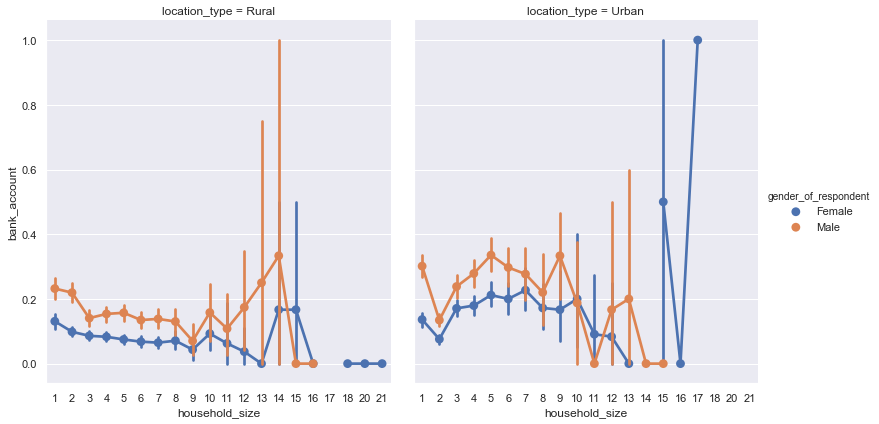

In [59]:
g = sns.factorplot(x="household_size", y="bank_account", hue="gender_of_respondent", col="location_type",
                   data=train, aspect=0.9, size=6, ci=95.0)

###### Lets create a binned-categorical value for household_size

In [70]:
bins = [0, 1, 10, 25]
labels = [1,2,3]
train['familysize'] = pd.cut(train['household_size'], bins=bins, labels=labels)
train.head(5)

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,familysize
0,Kenya,2018,uniqueid_1,1,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed,2
1,Kenya,2018,uniqueid_2,0,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent,2
2,Kenya,2018,uniqueid_3,1,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed,2
3,Kenya,2018,uniqueid_4,0,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private,2
4,Kenya,2018,uniqueid_5,0,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed,2


In [71]:
train.familysize.value_counts()

2    20276
1     3057
3      191
Name: familysize, dtype: int64

In [72]:
train.familysize = train.familysize.astype(np.int64)

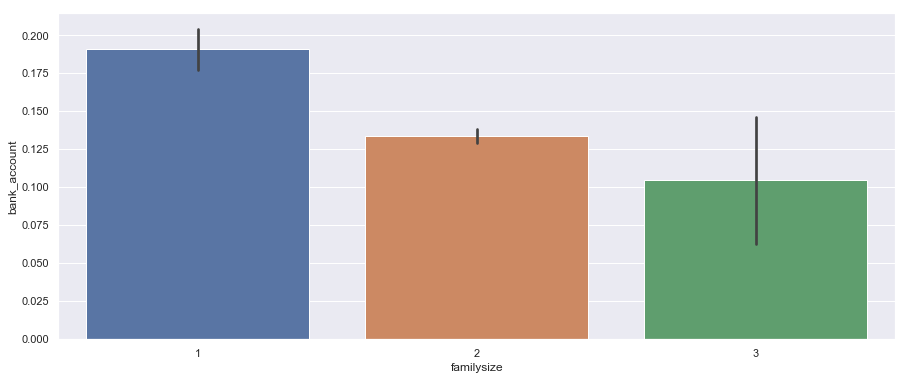

In [75]:
plt.figure(figsize=[15,6])
sns.barplot('familysize', 'bank_account', data=train)

This new binned variable based on household_size is clearly indicating that the bigger the house the person lives in, the less likely that person would have a bank_account.

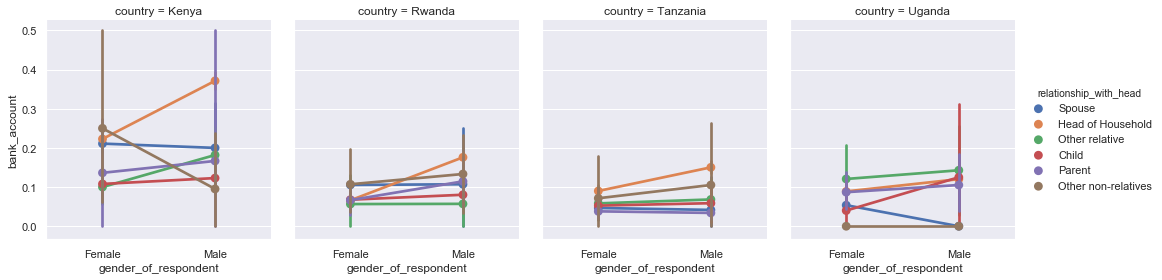

In [105]:
g = sns.factorplot(x="gender_of_respondent", y="bank_account", hue="relationship_with_head", col="country",
                   data=train, aspect=0.9, size=4, ci=95.0)

All countries have almost the same tendencies between male/female across all relationship_with_head categories with Kenya having a big difference between male head of house and female head of house.

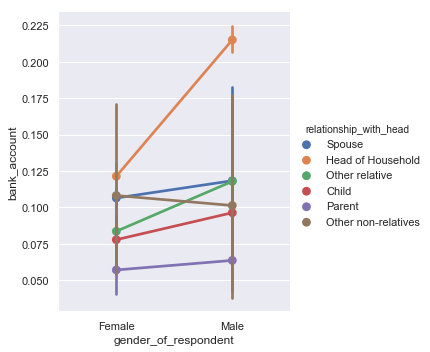

In [106]:
g = sns.factorplot(x="gender_of_respondent", y="bank_account", hue="relationship_with_head",
                   data=train, aspect=0.9, size=5, ci=95.0)

This shows that only head of household is different between genders.

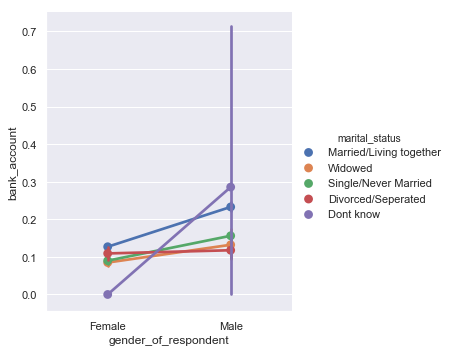

In [87]:
g = sns.factorplot(x="gender_of_respondent", y="bank_account", hue="marital_status",
                   data=train, aspect=0.9, size=5, ci=95.0)

The low number of samples of 'Dont know' is clear here with that category having a huge diff between males/females

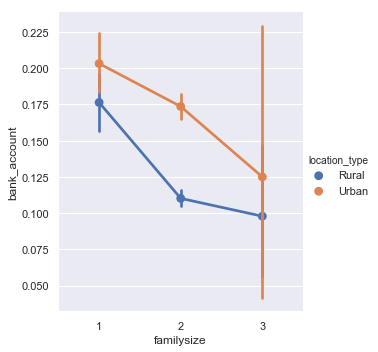

In [107]:
g = sns.factorplot(x="familysize", y="bank_account", hue="location_type",
                   data=train, aspect=0.9, size=5, ci=95.0)

The bigger the house the lower the chance you'd have a bank_account , and that pattern is followed by both urban locations and rural ones.

In [108]:
## binning the age!
bins = [10, 20, 30, 40,50,60,70,80,90,100]
labels = [1,2,3,4,5,6,7,8,9]
train['binnedage'] = pd.cut(train['age_of_respondent'], bins=bins, labels=labels)

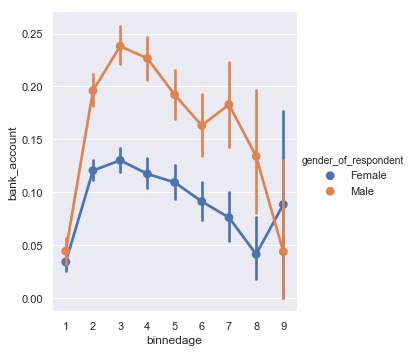

In [109]:
g = sns.factorplot(x="binnedage", y="bank_account", hue="gender_of_respondent",
                   data=train, aspect=0.9, size=5, ci=95.0)

Both genders follow the same pattern, it gets the highest between 20-30, and then starts slowly decreasing.

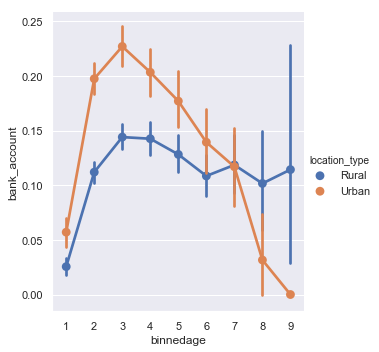

In [110]:
g = sns.factorplot(x="binnedage", y="bank_account", hue="location_type",
                   data=train, aspect=0.9, size=5, ci=95.0)

Young people in urban places have access to bank_accounts more than people in rural places, but older people surprisinly from both places share the same likelihood.

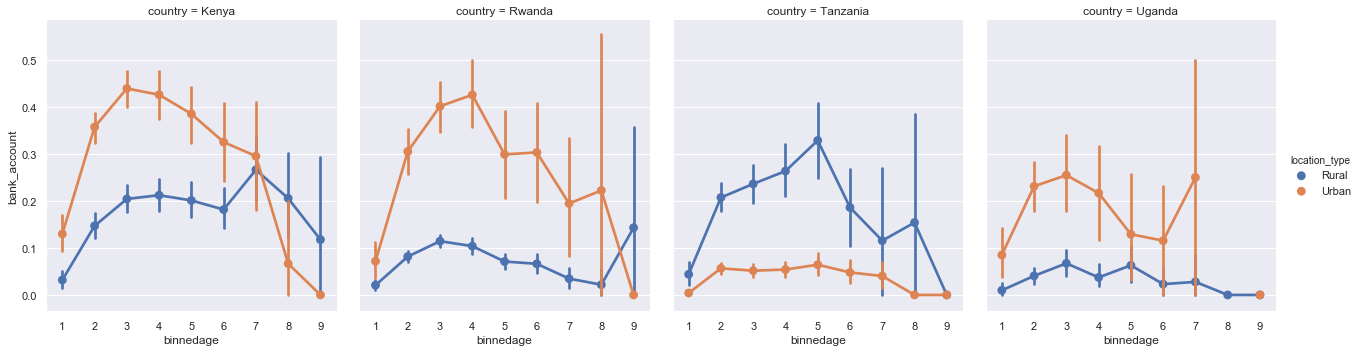

In [111]:
g = sns.factorplot(x="binnedage", y="bank_account", hue="location_type",col="country",
                   data=train, aspect=0.9, size=5, ci=95.0)

Only in Tanzania people from rural places across all ages have more chances of accessing a bank_account. Same pattern again, rise at 20's 30's starts declining after that.

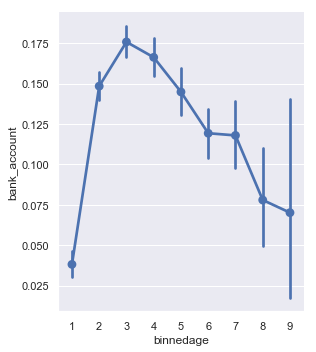

In [114]:
g = sns.factorplot(x="binnedage", y="bank_account",
                   data=train, aspect=0.9, size=5, ci=95.0)

In [127]:
train[train.binnedage==1].bank_account.value_counts()

0    2520
1     100
Name: bank_account, dtype: int64